In [ ]:
"""
This implementation is implemented from Tensorflow package with changed in hyperparameters and data structures  
"""
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_file = "/content/drive/MyDrive/NMT_04_2021/2nd_model_train_corpus.csv"

In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')

In [ ]:

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,?]+", " ", w)

  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
en, fr = create_dataset(path_to_file, 36000)
print(en[-1])
print(fr[-1])

<start> hazard ratio estimate is based on a cox proportionalhazard model adjusted for stratification factors beta microglobulin , albumin , and region <end>
<start> facteurs de stratification microglobuline , albumine et region geographique <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  #french, english
  # targ_lang, inp_lang = create_dataset(path, num_examples)
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.06)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

28200 28200 1800 1800


In [ ]:
target_tensor

array([[   1,  439,  399, ...,    0,    0,    0],
       [   1, 1396,   11, ...,    0,    0,    0],
       [   1,    7,   10, ...,    0,    0,    0],
       ...,
       [   1, 2630, 3297, ...,    0,    0,    0],
       [   1,  452,  287, ...,    0,    0,    0],
       [   1, 6799, 1433, ...,    0,    0,    0]], dtype=int32)

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
      # print(lang.index_word[t],end='')

In [ ]:
#Index - vectorize 
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[47])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[1200])


Input Language; index to word mapping
1 ----> <start>
15 ----> how
10 ----> to
54 ----> store
1882 ----> prepandrix
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4157 ----> tapotez
13 ----> le
4009 ----> porte
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 187]), TensorShape([64, 24]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    #Call the embedding layer of words == pareil à la fonction forward PyTorch
    x = self.embedding(x)
    # map th Input x to its output and it'sinitial state as hidden
    #gru layer  take the encoder input and its hidden state defined in the constructor
    output, state = self.gru(x, initial_state = hidden)
    #return the output for each X and its hidden state
    return output, state

  def initialize_hidden_state(self):
    #initialize and refresh the encoder units taken into account the length -- padding
    #and the batch size
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
#encoder object that takes the encoder variables
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
#read the input with its hidden, encoded and padded state
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 187, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 187, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 14342)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
#compile in a tf graph
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.2650
Epoch 1 Batch 100 Loss 1.8756
Epoch 1 Batch 200 Loss 1.8675
Epoch 1 Batch 300 Loss 1.7930
Epoch 1 Batch 400 Loss 1.6032
Epoch 1 Loss 1.8604
Time taken for 1 epoch 366.17855310440063 sec

Epoch 2 Batch 0 Loss 1.5285
Epoch 2 Batch 100 Loss 1.4749
Epoch 2 Batch 200 Loss 1.3852
Epoch 2 Batch 300 Loss 1.3291
Epoch 2 Batch 400 Loss 1.0605
Epoch 2 Loss 1.3079
Time taken for 1 epoch 348.6325080394745 sec

Epoch 3 Batch 0 Loss 1.0436
Epoch 3 Batch 100 Loss 1.0326
Epoch 3 Batch 200 Loss 0.9548
Epoch 3 Batch 300 Loss 0.9599
Epoch 3 Batch 400 Loss 0.7609
Epoch 3 Loss 0.9804
Time taken for 1 epoch 346.6724178791046 sec

Epoch 4 Batch 0 Loss 0.8122
Epoch 4 Batch 100 Loss 0.7136
Epoch 4 Batch 200 Loss 0.8039
Epoch 4 Batch 300 Loss 0.6208
Epoch 4 Batch 400 Loss 0.7217
Epoch 4 Loss 0.7210
Time taken for 1 epoch 348.36929631233215 sec

Epoch 5 Batch 0 Loss 0.5122
Epoch 5 Batch 100 Loss 0.5589
Epoch 5 Batch 200 Loss 0.4712
Epoch 5 Batch 300 Loss 0.6312
Epoch 5 Batch 400 Loss 0

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    #predictions are the dec_out
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    #a numpy array for each attention array 
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: ', sentence)
  print('Predicted translation: ',result)

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Input:  <start> emend mg hard capsules <end>
Predicted translation:  emend mg gelules <end> 


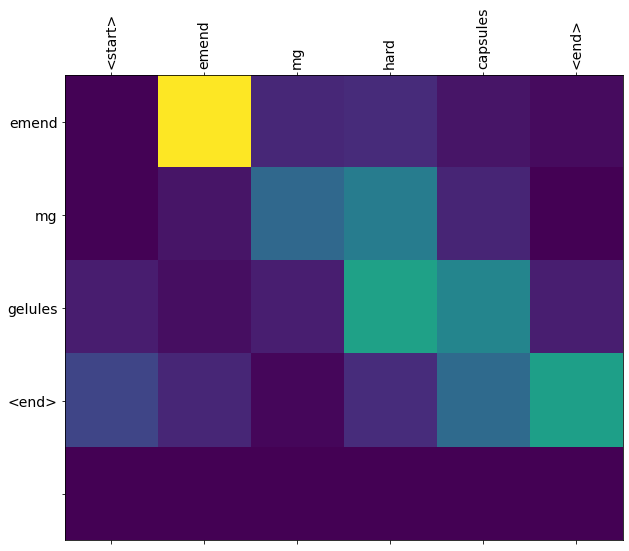

Input:  <start> per dose of . ml <end>
Predicted translation:  par dose de , ml <end> 


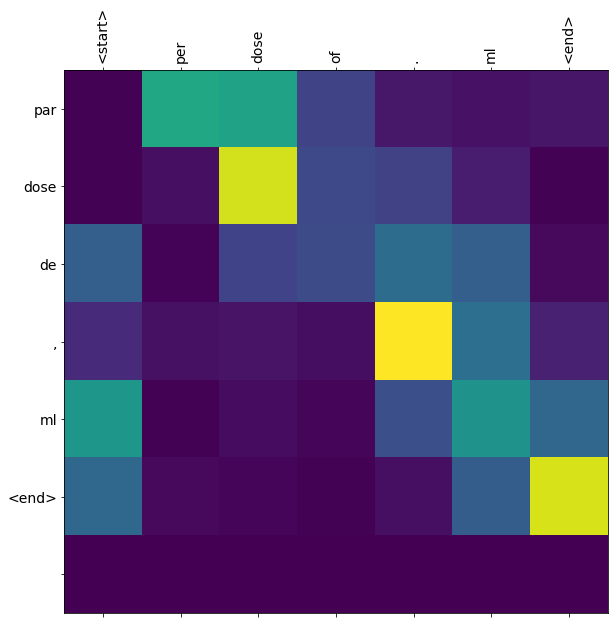

Input:  <start> chewable tablets <end>
Predicted translation:  comprimes a croquer <end> 


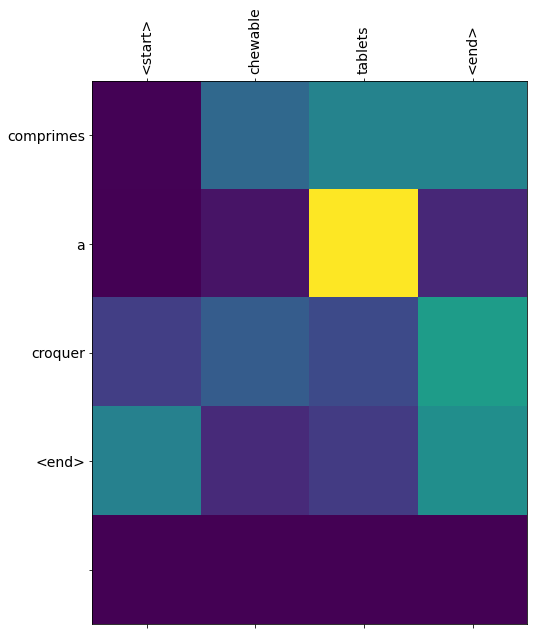

Input:  <start> what is prezista ? <end>
Predicted translation:  qu est ce que prezista ? <end> 


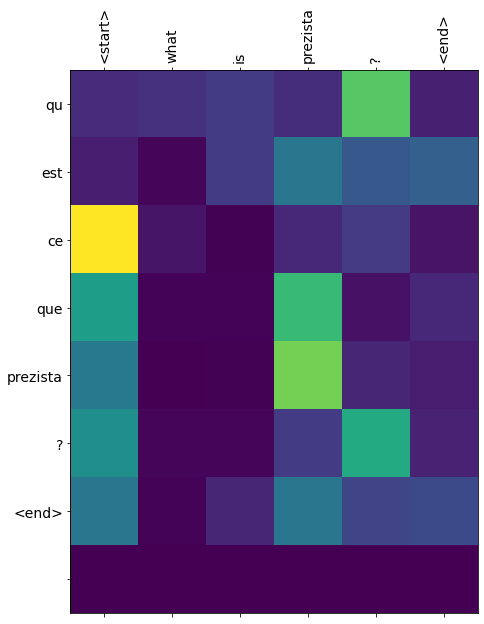

Input:  <start> changes in blood pressure <end>
Predicted translation:  modifications de la pression arterielle <end> 


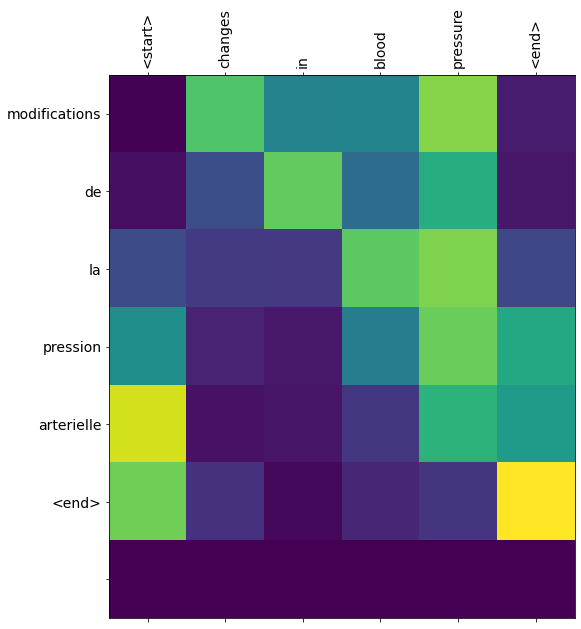

Input:  <start> how to take vimpat <end>
Predicted translation:  comment prendre vimpat <end> 


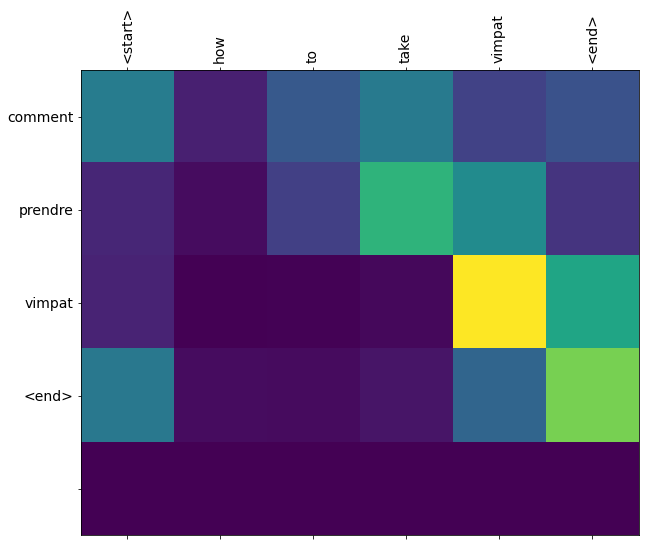

Input:  <start> water for injection <end>
Predicted translation:  eau pour preparations injectables <end> 


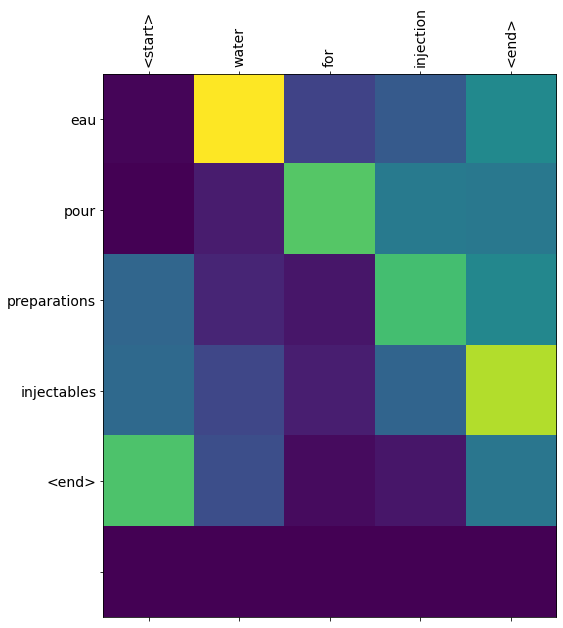

In [ ]:

# translate('Infuse one syringe into each infected quarter')
translate('EMEND 80 mg hard capsules')
translate('Per dose of 0.25 ml')
translate('Chewable tablets')
translate('What is Prezista?')
translate('changes in blood pressure')
translate('HOW TO TAKE VIMPAT')
translate('Water for injection')

In [ ]:
# translate(' efficacy results are presented for  the combined analysis of study protocols')
# translate('you may  have  removed  the  needle  from  your  skin too  quickly')
# translate('you  may  notice  small air  bubble  in  the prefilled  syringe')

In [ ]:
tester le modele sur des séqueneces du corpus de validation ...
translate('each filmcoated tablet contains gemfibrozil')

In [ ]:
# translate('neither the patient nor the doctor knew')

Input:  <start> dose calculation <end>
Predicted translation:  posologie normale <end> 


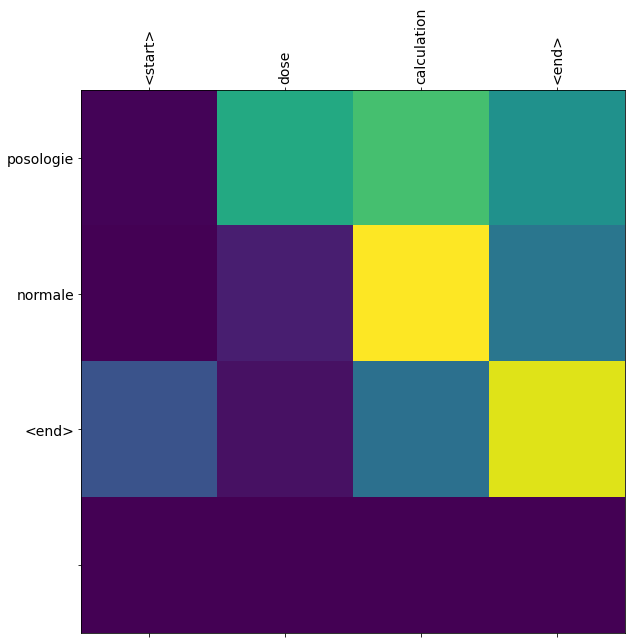

Input:  <start> shortness of breath <end>
Predicted translation:  augmentation des alat , sensation de vfend <end> 


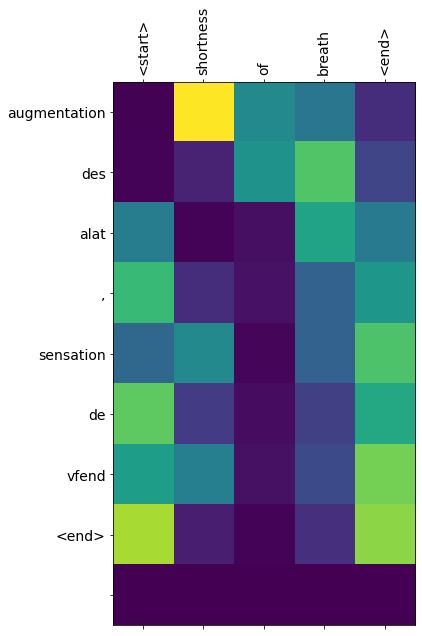

In [ ]:
translate('Dose calculation')
# This is a completely out of context sentence to make the network make wrong ptrfictions
translate("shortness of breath")

In [ ]:
translate('dilute before use')

Input:  <start> total daily dose <end>
Predicted translation:  dose jour mg <end> 


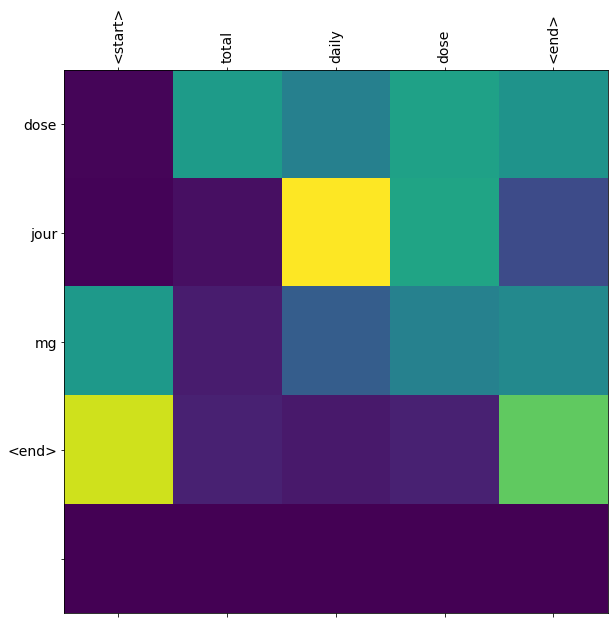

Input:  <start> the full epar <end>
Predicted translation:  l epar complet relatif a crixivan est disponible ici <end> 


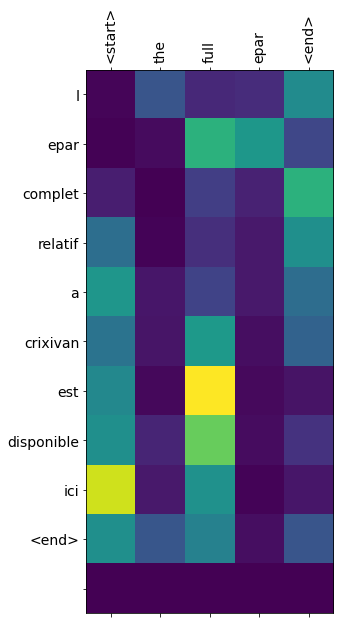

In [ ]:
translate('Total daily dose')
translate('The full epar')

Input:  <start> paclitaxel used in cancer treatment <end>
Predicted translation:  le capuchon de traitement en cours <end> 


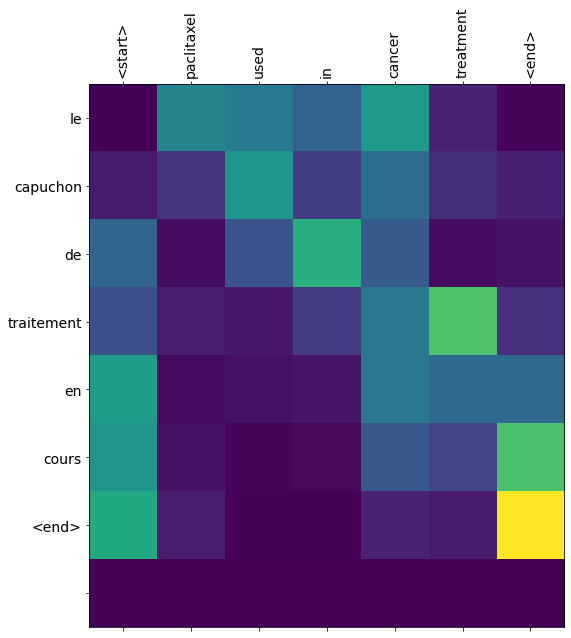

Input:  <start> what is faslodex <end>
Predicted translation:  dans quel cas faslodex ? <end> 


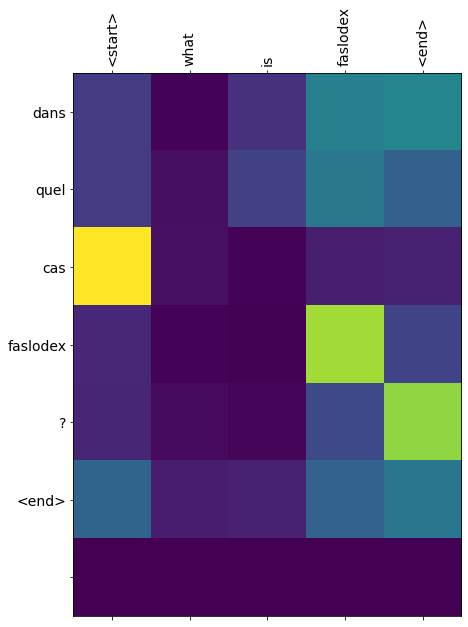

Input:  <start> endometrial cancer <end>
Predicted translation:  remeron soltab <end> 


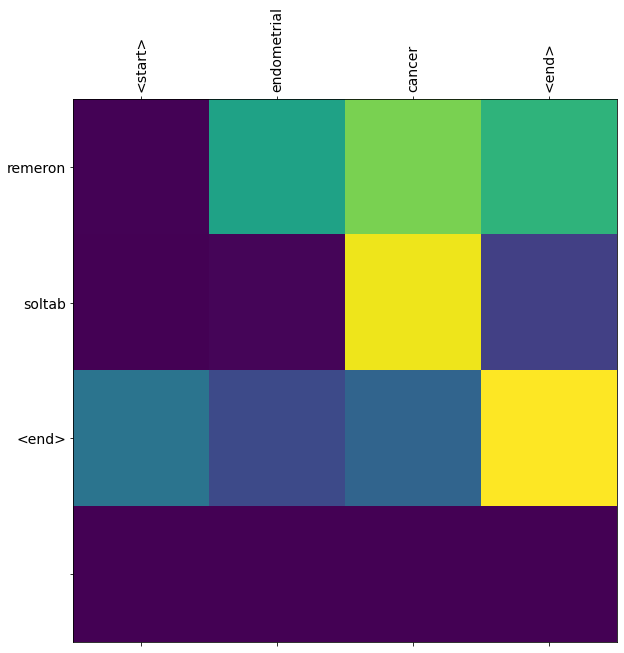

Input:  <start> how store fasturtec <end>
Predicted translation:  comment conserver fasturtec <end> 


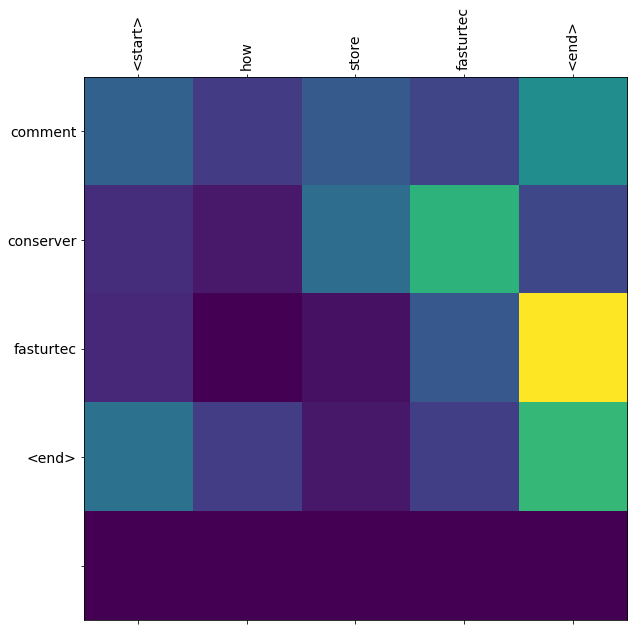

In [ ]:
translate('paclitaxel used in cancer treatment')
translate('what is faslodex')
translate('endometrial cancer')
translate('how store fasturtec')


Input:  <start> what is prezista ? <end>
Predicted translation:  qu est ce que prezista ? <end> 


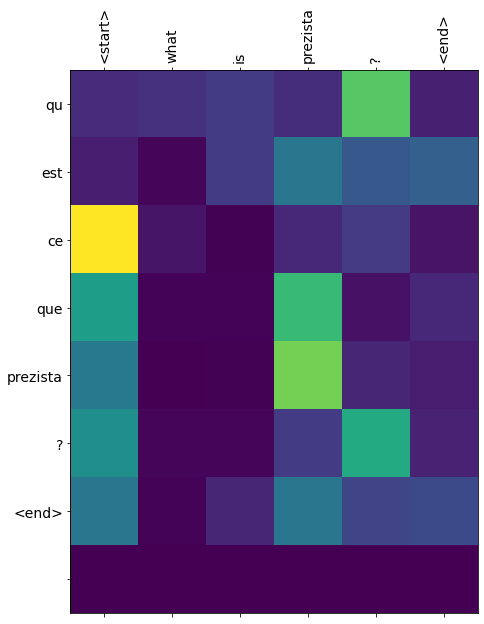

Input:  <start> vial protein label <end>
Predicted translation:  flacon de conservation du flacon <end> 


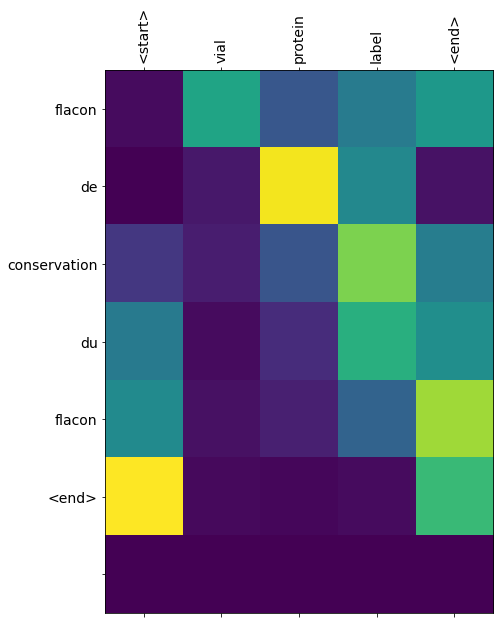

Input:  <start> epoetin alfa hexal <end>
Predicted translation:  epoetin alfa hexal <end> 


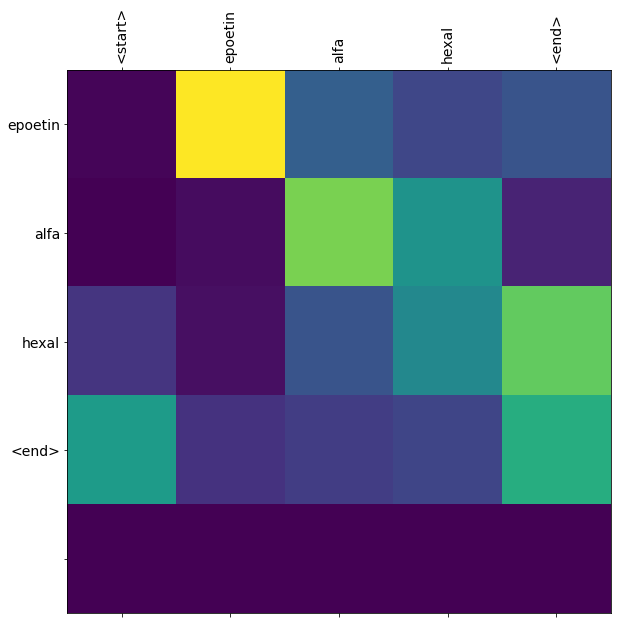

Input:  <start> family history <end>
Predicted translation:  des signes de sucre dans les patients <end> 


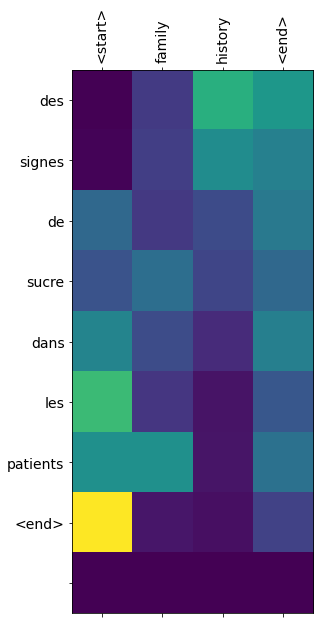

Input:  <start> reyataz is an antiviral medicine <end>
Predicted translation:  reyataz est un medicament antiviral <end> 


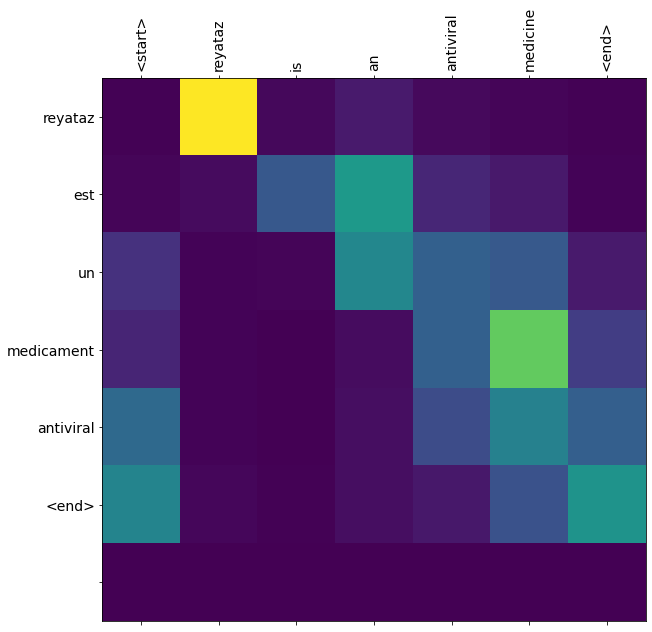

Input:  <start> use prometax oral solution within month of opening the bottle <end>
Predicted translation:  utiliser le volume de doses de doses le flacon <end> 


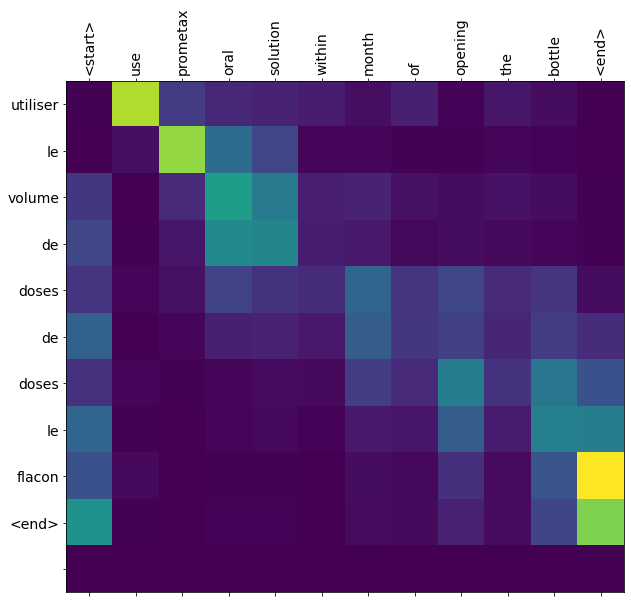

Input:  <start> acute renal injury <end>
Predicted translation:  insuffisance renale normale <end> 


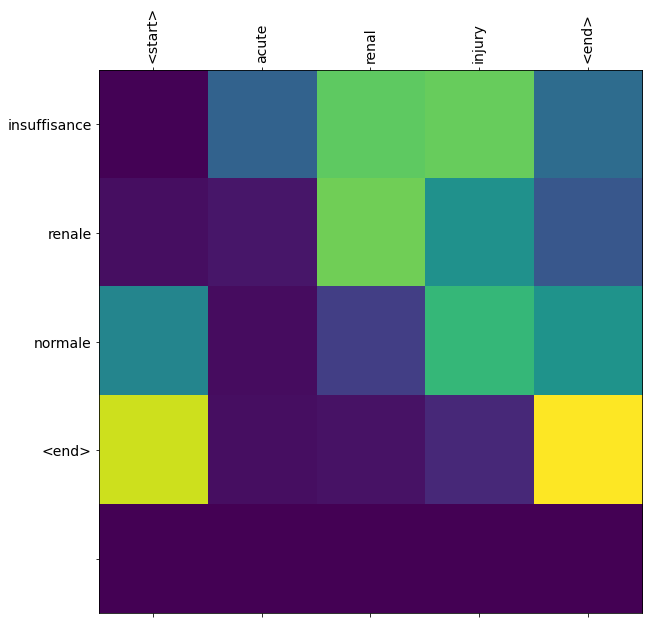

In [ ]:
translate('What is Prezista?')
# translate('Tracleer therefore causes blood vessels to dilate expand')
translate('VIAL PROTEIN LABEL')
translate('EPOETIN ALFA HEXAL') 
translate('family history')
translate('Reyataz is an antiviral medicine')
translate('Use prometax oral solution within month of opening the bottle')
translate('acute renal injury')
# translate('tracheal tube')